In [1]:
import pcen
import torch
import torchaudio
import pandas as pd
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pickle
from python_scripts.read_xwav_header import read_xwav_header
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
annot = pd.read_csv("data/pifsc_products_detections_annotations.csv")
annot.head()
uncompressed_files = os.listdir("data/audio_data/uncompressed")

In [172]:
annot[annot["label"] == "Vessel"]

,audit_name,flac_compressed_xwav_object,subchunk_index,label_is_strong,implicit_negatives,label,begin_rel_subchunk,end_rel_subchunk,begin_utc,end_utc
21425,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,4,False,False,Vessel,0.0,75.0,2005-11-29 22:47:30+00:00,2005-11-29 22:48:45+00:00
21430,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,3,False,False,Vessel,0.0,75.0,2005-12-10 02:31:15+00:00,2005-12-10 02:32:30+00:00
21440,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,0,False,False,Vessel,0.0,75.0,2005-12-25 16:18:45+00:00,2005-12-25 16:20:00+00:00
21453,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,23,False,False,Vessel,0.0,75.0,2006-01-04 00:22:44+00:00,2006-01-04 00:23:59+00:00
21454,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,0,False,False,Vessel,0.0,75.0,2006-01-04 02:04:20+00:00,2006-01-04 02:05:35+00:00
...,...,...,...,...,...,...,...,...,...,...
25553,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,465,False,False,Vessel,0.0,75.0,2015-05-01 03:00:00+00:00,2015-05-01 03:01:15+00:00
25556,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,201,False,False,Vessel,0.0,75.0,2015-04-29 18:00:00+00:00,2015-04-29 18:01:15+00:00
25620,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,145,False,False,Vessel,0.0,75.0,2016-04-01 01:33:45+00:00,2016-04-01 01:35:00+00:00
25622,postpub,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,10,False,False,Vessel,0.0,75.0,2016-04-05 23:01:15+00:00,2016-04-05 23:02:30+00:00


In [171]:
annot["label"].unique()

array(['Other', 'Mn', 'Background', 'Vessel', 'Fish', 'Device'],
      dtype=object)

In [141]:
annot.head(100)

,audit_name,flac_compressed_xwav_object,subchunk_index,label_is_strong,implicit_negatives,label,begin_rel_subchunk,end_rel_subchunk,begin_utc,end_utc
0,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,1,True,True,Other,0.213,0.213,2005-06-06 13:00:00.213000+00:00,2005-06-06 13:00:00.213000+00:00
1,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,13,True,True,Other,0.108,0.108,2005-06-06 14:15:00.108000+00:00,2005-06-06 14:15:00.108000+00:00
2,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,5,True,True,Other,0.143,0.143,2005-07-02 04:00:00.143000+00:00,2005-07-02 04:00:00.143000+00:00
3,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,17,True,True,Other,0.213,0.213,2005-07-02 05:15:00.213000+00:00,2005-07-02 05:15:00.213000+00:00
4,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,22,True,True,Other,0.213,0.213,2005-08-01 10:15:00.213000+00:00,2005-08-01 10:15:00.213000+00:00
...,...,...,...,...,...,...,...,...,...,...
95,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,18,True,True,Mn,57.142,57.774,2009-05-05 17:48:27.142000+00:00,2009-05-05 17:48:27.774000+00:00
96,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,18,True,True,Mn,60.996,61.839,2009-05-05 17:48:30.996000+00:00,2009-05-05 17:48:31.839000+00:00
97,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,18,True,True,Mn,65.178,66.302,2009-05-05 17:48:35.178000+00:00,2009-05-05 17:48:36.302000+00:00
98,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,18,True,True,Mn,68.481,69.606,2009-05-05 17:48:38.481000+00:00,2009-05-05 17:48:39.606000+00:00


In [142]:
annot[annot['flac_compressed_xwav_object'].str.contains("Hawaii_K_06_090505_164500")]

,audit_name,flac_compressed_xwav_object,subchunk_index,label_is_strong,implicit_negatives,label,begin_rel_subchunk,end_rel_subchunk,begin_utc,end_utc
76,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,4,True,True,Other,0.178,0.178,2009-05-05 17:00:00.178000+00:00,2009-05-05 17:00:00.178000+00:00
77,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,62.011,62.822,2009-05-05 17:31:02.011000+00:00,2009-05-05 17:31:02.822000+00:00
78,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,67.651,68.849,2009-05-05 17:31:07.651000+00:00,2009-05-05 17:31:08.849000+00:00
79,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,12,True,True,Mn,71.810,72.163,2009-05-05 17:31:11.810000+00:00,2009-05-05 17:31:12.163000+00:00
80,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,13,True,True,Mn,1.815,2.450,2009-05-05 17:31:16.815000+00:00,2009-05-05 17:31:17.450000+00:00
81,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,13,True,True,Mn,11.614,12.249,2009-05-05 17:31:26.614000+00:00,2009-05-05 17:31:27.249000+00:00
82,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,13,True,True,Mn,22.827,23.638,2009-05-05 17:31:37.827000+00:00,2009-05-05 17:31:38.638000+00:00
83,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,13,True,True,Mn,27.938,28.608,2009-05-05 17:31:42.938000+00:00,2009-05-05 17:31:43.608000+00:00
84,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,13,True,True,Mn,34.988,35.446,2009-05-05 17:31:49.988000+00:00,2009-05-05 17:31:50.446000+00:00
85,initial,gs://noaa-passive-bioacoustic/pifsc/audio/pipa...,13,True,True,Mn,37.596,38.160,2009-05-05 17:31:52.596000+00:00,2009-05-05 17:31:53.160000+00:00


In [173]:
data = {}

file_path = Path('data/audio_data/uncompressed/pifsc_audio_pipan_crosssm_pipan_crosssm_02_audio_Cross_A_02_060508_234813.d20.x.wav')
data["file_name"] = "Hawaii_K_06_090505_164500.d20.x.wav"
data["file_path"] = file_path
data["header"] = read_xwav_header(file_path)

waveform, sample_rate = torchaudio.load(file_path)
waveform = waveform

In [174]:
data["header"]

({'chunk_id': b'RIFF',
  'chunk_size': 45001060,
  'format': b'WAVE',
  'subchunk1_id': b'fmt ',
  'subchunk1_size': 16,
  'audio_format': 1,
  'num_channels': 1,
  'sample_rate': 10000,
  'byte_rate': 20000,
  'block_align': 2,
  'bits_per_sample': 16},
 {'harp_subchunk_id': b'harp',
  'harp_subchunk_size': 1016,
  'wav_version_number': 1,
  'firmware_version_number': b'1.17\x00\x00\x00\x00\x00\x00',
  'instrument_id': b'DL13',
  'site_name': b'XXXX',
  'experiment_name': b'Cross_02',
  'disk_sequence_number': 14,
  'disk_serial_number': b'12345678',
  'num_of_raw_files': 30,
  'longitude': -158.25368,
  'latitude': 18.72238,
  'depth': 396,
  'reserved': b'\x00\x00\x00\x00\x00\x00\x00\x00'},
 defaultdict(dict,
             {0: {'year': 6,
               'month': 5,
               'day': 8,
               'hour': 23,
               'minute': 48,
               'second': 13,
               'ticks': 0,
               'byte_loc': 1068,
               'byte_len': 1500000,
               '

In [175]:
waveform.shape

torch.Size([1, 22500000])

In [199]:
transform = pcen.StreamingPCENTransform(s=0.008,
                                        alpha=0.75,
                                        delta=30,
                                        r=0.1,
                                        n_fft=4096,
                                        n_mels=150,
                                        hop_length=350,
                                        sr=10_000,
                                        window=torch.hann_window(4096),
                                        return_complex=False,
                                        # normalized=True,
                                        f_max=4000,
                                        f_min=10,
                                        )

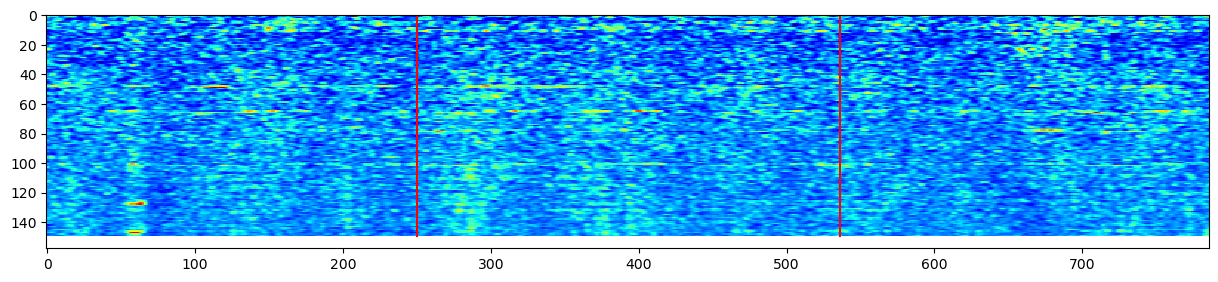

In [200]:
out = transform(waveform)

start, end = 11*75 + 48.174, 11*75 + 49.138
start, end = 22*75 + 10, 22*75 + 20
total = (data["header"][0]['chunk_size'] - 1060) / 20_000
p_start, p_end = start / total, end / total
spec_length = out.shape[1]
spec_start, spec_end = int(p_start * spec_length), int(p_end * spec_length)
spec_diff = spec_end - spec_start
spec_start, spec_end = max(0, spec_start - 250), min(spec_length, spec_end + 250)
plt.figure(figsize=(15,25))
plt.imshow(out[0][spec_start:spec_end, :].T.numpy(), cmap='jet', interpolation="none")
plt.vlines([250, 250 + spec_diff], 0, out.shape[2], color='red')

plt.show()

In [161]:
2250/64286

0.0349998444451358

In [158]:
out.shape

torch.Size([1, 64286, 300])

In [75]:
out[0][100:400, :].shape

torch.Size([300, 256])

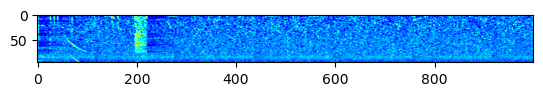

In [134]:
plt.imshow(out[0][:1_000, :].T.numpy(), cmap='jet')

In [108]:
start, end = 11*75 + 48.174, 11*75 + 49.138
total = (data["header"][0]['chunk_size'] - 1060) / 20_000
p_start, p_end = start / total, end / total
p_start, p_end

(0.38807733333333333, 0.3885057777777778)

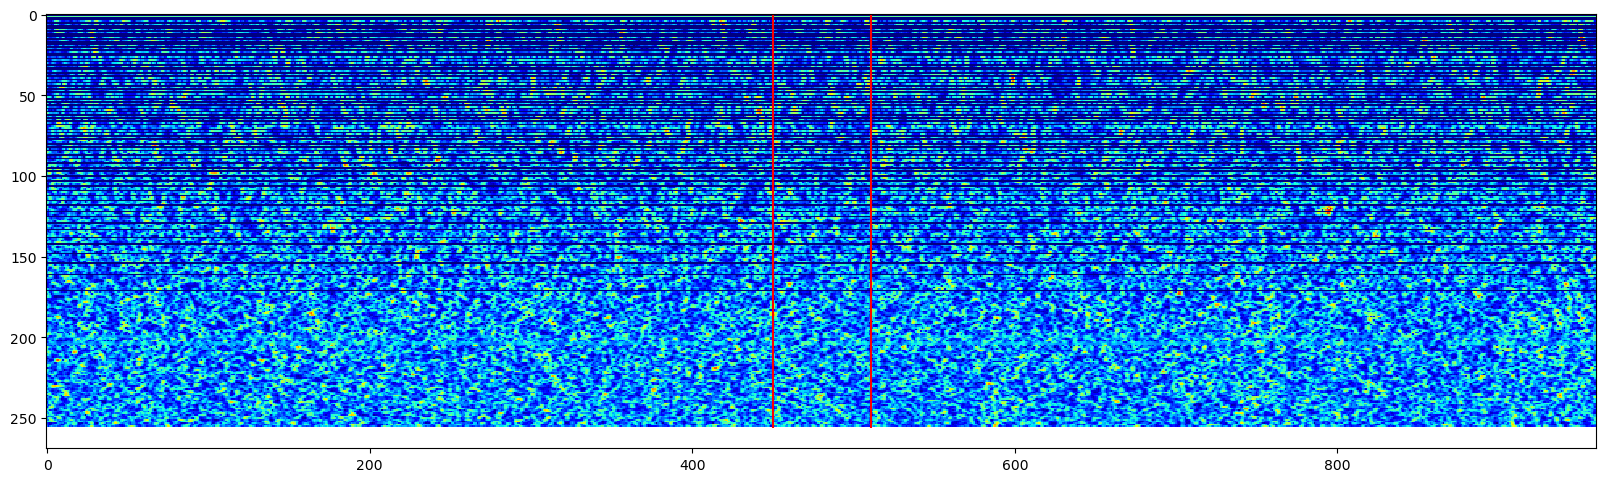

In [150]:
spec_length = out.shape[1]
spec_start, spec_end = int(p_start * spec_length), int(p_end * spec_length)
spec_diff = spec_end - spec_start
spec_start, spec_end = max(0, spec_start - 450), min(spec_length, spec_end + 450)
plt.figure(figsize=(20,20))
plt.imshow(out[0][spec_start:spec_end, :].T.numpy(), cmap='jet', interpolation="none")
plt.vlines([450, 450 + spec_diff], 0, out.shape[2], color='red')

plt.show()

In [125]:
(11*75) + 48.174

873.174

In [7]:
data['header']

({'chunk_id': b'RIFF',
  'chunk_size': 45001060,
  'format': b'WAVE',
  'subchunk1_id': b'fmt ',
  'subchunk1_size': 16,
  'audio_format': 1,
  'num_channels': 1,
  'sample_rate': 10000,
  'byte_rate': 20000,
  'block_align': 2,
  'bits_per_sample': 16},
 {'harp_subchunk_id': b'harp',
  'harp_subchunk_size': 1016,
  'wav_version_number': 1,
  'firmware_version_number': b'1.17\x00\x00\x00\x00\x00\x00',
  'instrument_id': b'DL13',
  'site_name': b'CSM1',
  'experiment_name': b'Cross_01',
  'disk_sequence_number': 4,
  'disk_serial_number': b'12345678',
  'num_of_raw_files': 30,
  'longitude': -18.43343,
  'latitude': 158.15221,
  'depth': 396,
  'reserved': b'\x00\x00\x00\x00\x00\x00\x00\x00'},
 defaultdict(dict,
             {0: {'year': 5,
               'month': 6,
               'day': 6,
               'hour': 12,
               'minute': 38,
               'second': 45,
               'ticks': 0,
               'byte_loc': 1068,
               'byte_len': 1500000,
               'w

In [9]:
waveform.shape

torch.Size([1, 22500000])

In [ ]:
lst = []
for file in uncompressed_files:
    data = {}
    if "Equator" in file:
        continue
    file_path = f"data/audio_data/uncompressed/{file}"
    data["file_name"] = file
    data["file_path"] = file_path
    data["header"] = read_xwav_header(file_path)
    
    waveform, sample_rate = torchaudio.load(file_path)
    
    del waveform
    pcen_spec = model.front_end(w)
    del w
    data["pcen_spec"] = pcen_spec
    lst.append(data)